In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/Users/MYK/Desktop/IRES/scripts')

import matplotlib.pyplot as plt
import numpy as np
import pywt
import scipy.stats
from collections import Counter

import fake_profile as fp

In [2]:
#accuracy of classifiers decreasee with SNR, obviously
noise_params = dict(noise=True, wn_sigma=.001)

amp_1 = [.006, .12, .015]; mu_1 = [47.5, 50, 52.5]; sd_1 = [.3, .4, .3]
amp_2 = [.006, .12, .005]; mu_2 = [47.5, 50, 52.5]; sd_2 = [.3, .4, .3]

norm = fp.fake_profile(amp_1, mu_1, sd_1, nbins=714); norm.construct_profile(**noise_params)
abnorm = fp.fake_profile(amp_2, mu_2, sd_2, nbins=714); abnorm.construct_profile(**noise_params)

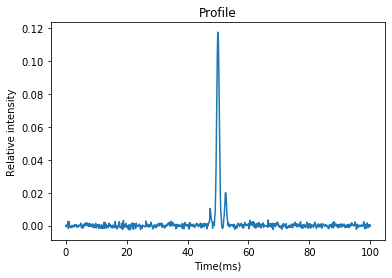

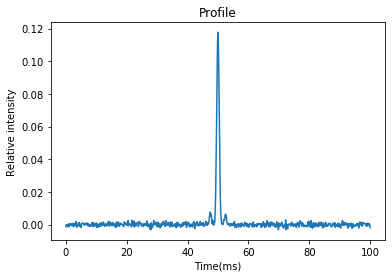

In [3]:
norm.plot()
abnorm.plot()

### Generate profiles

In [4]:
nprofs = 1000

profs = []
#target values
y = []

for i in range(nprofs):
    class_ = np.random.randint(2)
    y.append(class_)
    
    #normal mode
    if class_ == 0:
        norm = fp.fake_profile(amp_1, mu_1, sd_1)
        norm.construct_profile(**noise_params)
        profs.append(norm.profile)
    else:
        abnorm = fp.fake_profile(amp_2, mu_2, sd_2)
        abnorm.construct_profile(**noise_params)
        profs.append(abnorm.profile)
profs = np.array(profs)

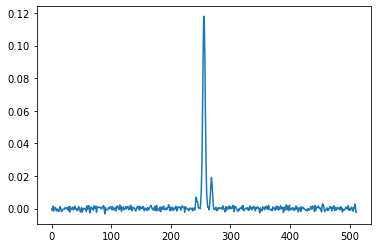

In [5]:
plt.plot(profs[0])

### Functions to get features

In [6]:
# Functions copied from http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy
 
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]
 
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]
 
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [7]:
def get_dwt_features(profs, wavelet='haar', level=None, nfeatures=None):
    '''Function to decompose each profile, get features at each level and return 
    a feature matrix which will be nprofs X nfeatures.
    
    Parameters
    ----------
    
    profs : 2d array
    NumPy 2d array, each row corresponds to profile data.
    nprofs X nbins
    
    wavelet : str
    Wavelet name to use in wavelet decomposition. Must come from
    pywt.wavelist().
    
    max_level : int
    Maximum level to apply wavelet decomposition to. If None,
    pywt will automatically use maximum level possible.
    
    nfeatures : int
    Number of features. Set to 12 by default if using
    functions from Ahmet Taspinar's website.
    
    Returns
    -------
    matrix : 2d array
    Matrix containing features per profile. nprofs X nfeatures.
    '''
    nprofs = len(profs)
    
    #feature_matrix
    if nfeatures is None:
        if level is None:
            max_level =  pywt.dwt_max_level(len(profs[0]), wavelet)
            nfeatures = len(get_features(profs[0])) * (max_level+1)
        else:
             nfeatures = len(get_features(profs[0])) * (level+1)
    matrix = np.zeros((nprofs, nfeatures))
    
    for i in range(len(profs)):
        features = []
        coeffs = pywt.wavedec(profs[i], wavelet, mode='periodization', level=level)
        for c in coeffs:
            features += get_features(c)
        matrix[i] = features
    
    return matrix

In [8]:
X = get_dwt_features(profs)

### Generate training and test set

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

### Random Forest Classifier

In [157]:
rnd_clf = RandomForestClassifier(max_leaf_nodes=10)
rnd_clf.fit(X_train, y_train)

cross_val_score(rnd_clf, X_train, y_train, scoring='accuracy')

/Users/MYK/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/MYK/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([1., 1., 1.])

In [158]:
#predict on test set
y_pred = rnd_clf.predict(X_test)

In [159]:
#test set performance
accuracy_score(y_test, y_pred)

1.0

### SVM Classifier

In [160]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [161]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='linear', C=10))
])

svm_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [162]:
cross_val_score(svm_pipeline, X_train, y_train, cv=10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [163]:
svm_pipeline.score(X_test, y_test)

1.0

### XGBoost with Gridsearch on hyperparam

In [164]:
import xgboost
from sklearn.model_selection import GridSearchCV
import scipy.stats as ss

In [165]:
xgb_clf = xgboost.XGBClassifier()

#redid several times to zoom in on most optimal values
param_grid = [{
    'max_depth': np.arange(6, 10),
    'learning_rate': np.linspace(2.6, 2.8, 10),
    'gamma': np.linspace(1.7, 1.9, 10)
}]

grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, n_jobs=-1)

In [166]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
             param_grid=[{'gamma': array([1.7       , 1.72222222, 1.74444444, 1.76666667, 1.78888889,
       1.81111111, 1.83333333, 1.85555556, 1.87777778, 1.9       ]),
                          'learning_rate': array([2.6       , 2.62222222, 2.64444444, 2.66666667, 2.68888889,
       2.71111111, 2.73333333, 2.75555556, 2.77777778, 2.8       ]),
     

In [167]:
print(grid_search.best_params_)
grid_search.best_estimator_

{'gamma': 1.7, 'learning_rate': 2.6, 'max_depth': 6}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.7,
              learning_rate=2.6, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [184]:
#now use gridsearched values to fit and predict
xgb_gridded = xgboost.XGBClassifier(**grid_search.best_params_)
xgb_gridded.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.7,
              learning_rate=2.6, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [185]:
y_pred = xgb_gridded.predict(X_test)

In [186]:
accuracy_score(y_test, y_pred)

1.0

### K-Means Unsupervised Learning
Remember K-Means method requires feature scaling

In [172]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [173]:
n_clusters = 2

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=n_clusters))
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=2, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [174]:
y_pred = pipeline.predict(X_test)

#class 0/1 does not correspond to mode 0/1
y_pred = 1 - y_pred

In [175]:
accuracy_score(y_test, y_pred)

1.0

In [187]:
for i,j in zip(y_test, y_pred):
    print(i,j)

1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
0 0
1 1
0 0
1 1
1 1
0 0
0 0
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
0 0
0 0
0 0
1 1
1 1
0 0
0 0
1 1
0 0
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
0 0
1 1
0 0
1 1
0 0
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
0 0
0 0
0 0
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 1
0 0
1 1
0 0
1 1
0 0
0 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
0 0
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
0 0
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
0 0
